In [1]:
import torch
import torch.nn as nn
import pandas as pd
from dataset import HddSmartDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

/Users/lion397/homebrew/Caskroom/miniforge/base/envs/ecs273/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


In [2]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, shuffle=True)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


In [3]:
dataset = HddSmartDataset(use_mfg=True, use_normalized=True, use_raw=False)
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
print(dataset.data_values['MFG_HP'])

   smart_1_normalized  smart_2_normalized  smart_3_normalized  \
0                0.68                 0.0                0.92   
1                1.17                 0.0                0.92   
2                0.83                 0.0                0.92   
3                1.00                 1.0                1.00   
4                0.82                 0.0                0.89   

   smart_4_normalized  smart_5_normalized  smart_7_normalized  \
0                 1.0                 1.0                0.91   
1                 1.0                 1.0                0.89   
2                 1.0                 1.0                0.94   
3                 1.0                 1.0                1.00   
4                 1.0                 1.0                0.91   

   smart_8_normalized  smart_9_normalized  smart_10_normalized  \
0                 0.0                0.75                  1.0   
1                 0.0                0.58                  1.0   
2                 0.

In [4]:
class Classifier(nn.Module):

    def __init__(self, lr = 0.01):
        super().__init__()

        self.lr = lr
        if 1:
            self.model = nn.Sequential(
                nn.Linear(90, 1000),
                nn.LeakyReLU(0.02),
                nn.Linear(100, 200),
                nn.LeakyReLU(0.02),
                nn.Linear(200,2),
                nn.Sigmoid(),
            )
        
        self.loss_funciton = nn.CrossEntropyLoss()
        #self.loss_funciton = nn.MSELoss()

        self.optimiser = torch.optim.SGD(self.parameters(), lr = self.lr)
        #self.optimiser = torch.optim.Adam(self.parameters())

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    
    def train(self, inputs, targets):

        outputs = self.forward(inputs)

        loss = self.loss_funciton(outputs, targets)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
            pass

        if self.counter % 10000 == 0:
            print(f"counter = {self.counter}")
            pass

    def plot_progress(self):

        df = pd.DataFrame(self.progress, columns=['loss'])
        #df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
        df.plot(ylim=(0,1.0), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))



In [5]:
C = Classifier(lr = 0.01).to(device)
loader = DataLoader(dataset=datasets['train'], batch_size=64, shuffle=True)
n_epochs = 1
for epoch in range(n_epochs):
    print(f"epoch {epoch}")
    for label, image_tensor, target_tensor in tqdm(loader):
        C.train(image_tensor.to(device), targets=target_tensor.to(device))
C.plot_progress()

epoch 0


  0%|          | 0/2840 [00:00<?, ?it/s]

: 

: 

0 tensor([1.0000e+00, 8.6597e-16], device='mps:0')


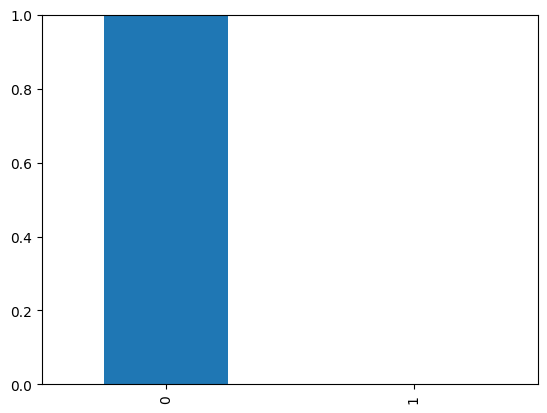

In [20]:
test_dataset = dataset
gt, img_tensor, _ = test_dataset[50000]
with torch.no_grad():
    output = C.forward(img_tensor.to(device))
pd.DataFrame(output.cpu().numpy()).plot(kind='bar', legend=False, ylim=(0,1))
print(gt,output)


In [18]:
score = 0
items = 0
test_dataset = datasets["val"]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
for labels, image_data_tensor, target_tensor in tqdm(test_loader):
    with torch.no_grad():
        answers = C.forward(image_data_tensor.to(device)).cpu().numpy()
        for answer, label in zip(answers,labels):
            if answer.argmax() == label:
                score += 1
                pass
            items += 1


print(score, items, score/items)

100%|██████████| 947/947 [00:06<00:00, 151.87it/s]

58927 60584 0.9726495444341741
